## The Stokes flow (calculation of effective permeability)

#### (1.1) The governing equation 
The governing PDE is
\begin{equation}
\begin{split}
 -\mu\nabla^2{\bf u} + \nabla p &={\bf 0}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity vector, ${\bf f}$ is the applied body force, $\mu$ is the dynamic viscosity.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
#### (1.2) The continuum and constitutive formulations
\begin{equation}
\begin{split}
- \nabla\cdot {\bf \sigma}  &= {\bf 0}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega 
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) 
\end{equation}
is the Cauchy stress tensor, and $p=-tr({\bf \sigma})/2$.
#### (1.3) The weak form
\begin{equation}
\begin{split}
\int {\bf \sigma} \cdot\nabla^T\psi ~dx =  {\bf 0}
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) ,
\end{equation}
and $p=-tr({\bf \sigma})/2$.
#### (1.4) The problem
The domain is given in the following figure and the initial/boundary conditions are given as:
- **In flow:** ${\bf u}=(4y(1-y), 0)$
- **Out flow:** $p=0$
- **non-slip wall:** ${\bf u}={\bf 0}$
- **Cylinder:** ${\bf u=0}$
  
For the parameters in the equation, we set  $\mu=0.01$.

### (1) The PINN method

dict_keys(['__header__', '__version__', '__globals__', 'x', 'u', 'v', 'p', 'dpx', 'dpy'])


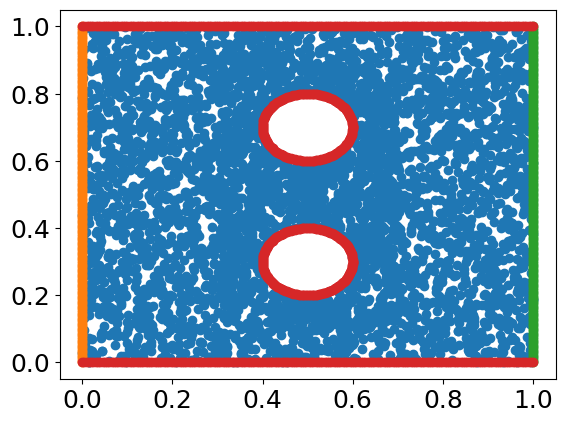

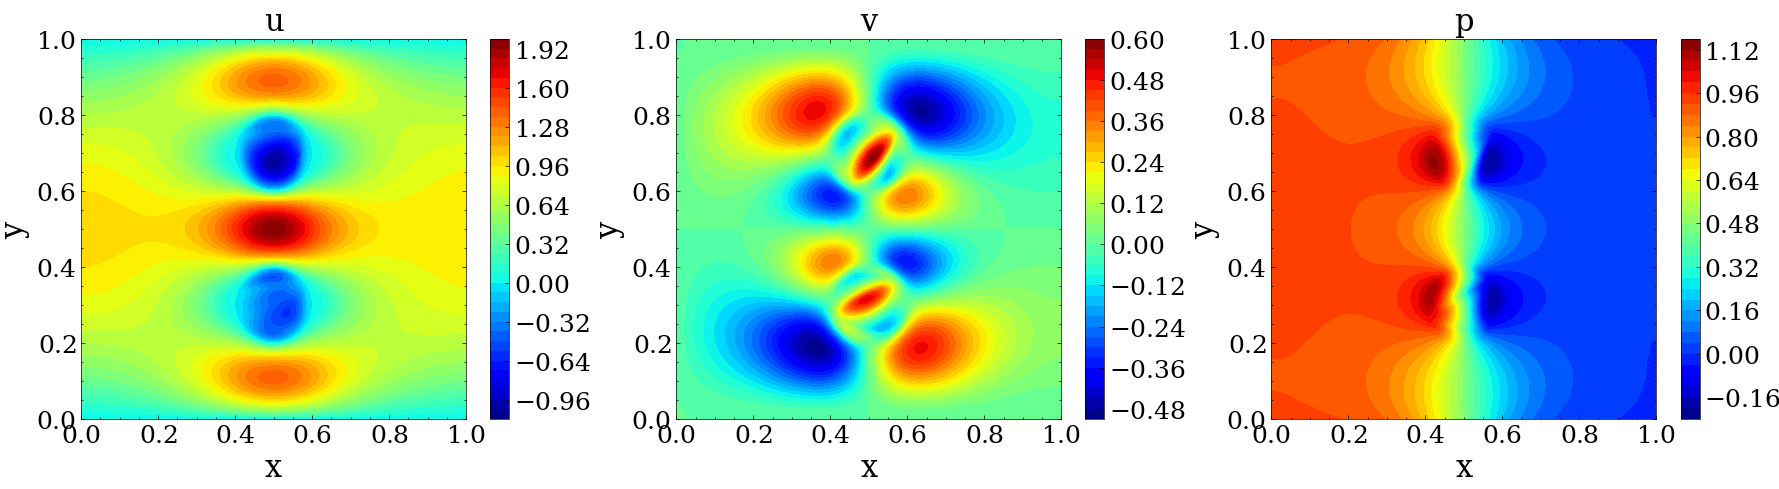

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch
import scipy.io
from Utils.GenPoints import Point2D
from Utils.PlotFigure import Plot
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 1232
device = 'cuda:0'
dtype = torch.float32
setup_seed(random_seed)
problem_name = 'Stokes_hole'
####################################
# Load data
####################################
try:
    data = h5py.File('../../Problems/Stokes/truth_stokes_hole.mat', 'r')
except:
    data = scipy.io.loadmat('../../Problems/Stokes/truth_stokes_hole.mat')
print(data.keys())
u_test, v_test, x_test = np.array(data['u']), np.array(data['v']), np.array(data['x'])
p_test, dpx_test = np.array(data['p']), np.array(data['dpx'])
u_test = torch.tensor(u_test.reshape(-1,1), dtype=dtype)
v_test = torch.tensor(v_test.reshape(-1,1), dtype=dtype)
p_test = torch.tensor(p_test.reshape(-1,1), dtype=dtype)
dpx_test = torch.tensor(dpx_test.reshape(-1,1), dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
######################################
# Setups of the problem 
######################################
N_in, N_refine, N_bd_each_edge = 4000, 1000, 200
#
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype, random_seed=random_seed)
refineGen = Point2D(x_lb=[0.3, 0.1], x_ub=[0.7, 0.9], dataType=dtype, random_seed=random_seed)
# The inner points
x_in = pointGen.inner_point(num_sample_or_mesh=N_in, method='hypercube')
x_in_refine = refineGen.inner_point(num_sample_or_mesh=N_refine, method='hypercube')
x_in_train = torch.cat((x_in, x_in_refine), axis=0)
index_1 = torch.where(torch.linalg.norm(x_in_train-torch.tensor([0.5,0.3]), axis=1, keepdims=True)<=0.1+1e-4)[0]
index_2 = torch.where(torch.linalg.norm(x_in_train-torch.tensor([0.5,0.7]), axis=1, keepdims=True)<=0.1+1e-4)[0]
index = [i for i in range(x_in_train.shape[0]) if i not in index_1 and i not in index_2]
x_in_train = x_in_train[index,:]
# The boundary points
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='mesh')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
x_cld1 = pointGen.boundary_point_sphere(N_bd_each_edge, xc=[0.5,0.3], radius=0.1, method='mesh')
x_cld2 = pointGen.boundary_point_sphere(N_bd_each_edge, xc=[0.5,0.7], radius=0.1, method='mesh')
x_cld = torch.cat((x_cld1, x_cld2), axis=0)
###########################################
x_inflow = x_lt
x_outflow = x_rt
x_wall = torch.cat((x_up, x_bt, x_cld), axis=0)
############################################
plt.figure()
plt.scatter(x_in_train[:,0], x_in_train[:,1])
plt.scatter(x_inflow[:,0], x_inflow[:,1])
plt.scatter(x_outflow[:,0], x_outflow[:,1])
plt.scatter(x_wall[:,0], x_wall[:,1])
plt.show()
#######################################
Plot.show_2d_list(x_test, [u_test, v_test, p_test],['u', 'v', 'p'])

### (2) Define the loss class and train the model 

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN

#####################################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, 
    dataType=dtype).get_testFun()
# 
xc_train = x_in_train.reshape(-1, 1, 2)
_, R_train = pointGen.weight_centers(n_center=xc_train.shape[0], R_max=1e-4, R_min=1e-4)

def fun_u_inflow(x):
    return 4.*x[...,1:2]*(1.-x[...,1:2])
#
u_inflow_true = fun_u_inflow(x_inflow)
    
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.device = self.solver.device
        self.model_psip = solver.model_dict['psi_p']
        #
        self.int_grid = int_grid.to(self.device)
        self.solver.getLoss = torch.nn.MSELoss()

    def get_values(self, x_device):
        '''
        '''
        psi_p = self.model_psip(x_device)
        psi, p = psi_p[...,0:1], psi_p[:,1:2]
        #
        dpsi = self.solver.grad(psi, [x_device])[0]
        u, v = dpsi[...,1:2], - dpsi[...,0:1]
        #
        s11, s22, s12 = psi_p[...,2:3], psi_p[...,3:4], psi_p[...,4:5]
        
        return u, v, p, s11, s22, s12

    def Loss_pde(self, x_in=None, mu=0.01):
        '''
        '''
        _, R = pointGen.weight_centers(n_center=x_in.shape[0], R_max=1e-4, R_min=1e-4)
        xc, R = x_in, R.to(self.device)
        ################################## The collocation points
        x_in = (self.int_grid * R + xc).reshape(-1,2)
        x_list = torch.split(x_in, split_size_or_sections=1, dim=1)
        x_list = [Variable(x, requires_grad=True) for x in x_list]
        x = torch.cat(x_list, dim=1)
        ###########################
        u, v, p, s11, s22, s12 = self.get_values(x)
        #
        du = self.solver.grad(u, x_list)
        dv = self.solver.grad(v, x_list)
        #
        ds11_x = self.solver.grad(s11, x_list[0:1])[0]
        ds22_y = self.solver.grad(s22, x_list[1:2])[0]
        ds12 = self.solver.grad(s12, x_list)
        ########################### Eq_1 & Eq_2
        res1 = ds11_x + ds12[1]
        res2 = ds12[0] + ds22_y
        ########################### Eq_3 & Eq_4
        res3 = -p + 2*mu*du[0] - s11
        res4 = -p + 2*mu*dv[1] - s22
        res5 = mu*(du[1]+dv[0]) - s12
        ########################### Eq6
        res6 = p + (s11+s22)/2
        ###############################
        loss = (self.solver.getLoss(res1, torch.zeros_like(res1)) + 
                self.solver.getLoss(res2, torch.zeros_like(res2)) +
                self.solver.getLoss(res3, torch.zeros_like(res3)) +
                self.solver.getLoss(res4, torch.zeros_like(res4)) +
                self.solver.getLoss(res5, torch.zeros_like(res5)) +
                self.solver.getLoss(res6, torch.zeros_like(res6)) 
               )
        
        return loss * 10.

    def Loss_bd(self):
        loss = 0.
        ######################### The wall
        xwall = Variable(x_wall, requires_grad=True).to(self.device)
        u_wall, v_wall, _, _, _, _ = self.get_values(xwall)
        #
        loss += self.solver.getLoss(u_wall, torch.zeros_like(u_wall)) 
        loss += self.solver.getLoss(v_wall, torch.zeros_like(v_wall))
        ######################### The inflow 
        xinflow = Variable(x_inflow, requires_grad=True).to(self.device)
        u_inflow, v_inflow, _, _, _, _ = self.get_values(xinflow)
        #
        loss += self.solver.getLoss(u_inflow, u_inflow_true.to(self.device)) 
        loss += self.solver.getLoss(v_inflow, torch.zeros_like(v_inflow))
        ######################### The outflow 
        xoutflow = Variable(x_outflow, requires_grad=True).to(self.device)
        _, _, p_outflow, _, _, _ = self.get_values(xoutflow)
        loss += self.solver.getLoss(p_outflow, torch.zeros_like(p_outflow))
        
        return loss * 2.
        
    def Error(self):
        '''
        Input:
            x_in_test: size(n_test, dx)
        '''
        x = Variable(x_test, requires_grad=True).to(self.device)
        u_pred, v_pred, p_pred, _, _, _ = self.get_values(x)
        #########
        error_u = self.solver.getError(u_pred, u_test.to(self.device))
        error_v = self.solver.getError(v_pred, v_test.to(self.device))
        #########
        error = [error_u, error_v]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.PINN import PINN
solver = PINN.Solver(device, dtype=dtype)
#
psi_p_model = solver.getModel(layers_list=[2]+[40]*8+[5], activation='Tanh', netType='FCNet')

### (3) Training and make prediction

#### (3.1) Train the model

In [3]:
model_dict = {'psi_p': psi_p_model}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type=None, lbfgs=True, max_iter=5000)
solver.train(LossClass, xc_train, batch_size_in=int(np.ceil(xc_train.shape[0]/5)), epochs=10000, 
             **{'save_path':f'saved_models/'})
solver.train_lbfgs(LossClass, xc_train, epochs=200, **{'save_path':f'saved_models/'})

  1%|▊                                                                             | 100/10000 [00:21<35:13,  4.68it/s]

Epoch:100 Time:21.5257, loss_in:0.002783, loss_bd:0.167081
          lr: 0.001 l2_err [0.7282312512397766, 1.2760545015335083]


  2%|█▌                                                                            | 200/10000 [00:42<34:47,  4.69it/s]

Epoch:200 Time:42.8560, loss_in:0.004219, loss_bd:0.154365
          lr: 0.001 l2_err [0.7299394607543945, 1.3373332023620605]


  3%|██▎                                                                           | 300/10000 [01:04<34:27,  4.69it/s]

Epoch:300 Time:64.1630, loss_in:0.004803, loss_bd:0.148849
          lr: 0.001 l2_err [0.7204368114471436, 1.3250550031661987]


  4%|███▏                                                                          | 401/10000 [01:21<25:13,  6.34it/s]

Epoch:400 Time:81.0325, loss_in:0.020717, loss_bd:0.086195
          lr: 0.001 l2_err [0.5206400156021118, 1.1443274021148682]


  5%|███▉                                                                          | 501/10000 [01:37<25:14,  6.27it/s]

Epoch:500 Time:96.9247, loss_in:0.026737, loss_bd:0.071270
          lr: 0.001 l2_err [0.5170451998710632, 1.1166086196899414]


  6%|████▋                                                                         | 601/10000 [01:53<24:56,  6.28it/s]

Epoch:600 Time:112.9204, loss_in:0.031046, loss_bd:0.064396
          lr: 0.001 l2_err [0.5138121247291565, 1.1152210235595703]


  7%|█████▍                                                                        | 701/10000 [02:08<24:05,  6.43it/s]

Epoch:700 Time:128.6844, loss_in:0.032885, loss_bd:0.059139
          lr: 0.001 l2_err [0.5143581628799438, 1.105423092842102]


  8%|██████▏                                                                       | 801/10000 [02:24<24:13,  6.33it/s]

Epoch:800 Time:144.5205, loss_in:0.033756, loss_bd:0.056141
          lr: 0.001 l2_err [0.5138934850692749, 1.0872676372528076]


  9%|███████                                                                       | 901/10000 [02:40<23:56,  6.33it/s]

Epoch:900 Time:160.3304, loss_in:0.033223, loss_bd:0.054740
          lr: 0.001 l2_err [0.48972371220588684, 1.0501751899719238]


 10%|███████▋                                                                     | 1001/10000 [02:56<23:57,  6.26it/s]

Epoch:1000 Time:176.2890, loss_in:0.033424, loss_bd:0.049342
          lr: 0.001 l2_err [0.42467060685157776, 0.9231813549995422]


 11%|████████▍                                                                    | 1101/10000 [03:12<23:24,  6.34it/s]

Epoch:1100 Time:192.0281, loss_in:0.035793, loss_bd:0.043753
          lr: 0.001 l2_err [0.3992510437965393, 0.8786316514015198]


 12%|█████████▏                                                                   | 1201/10000 [03:27<23:02,  6.37it/s]

Epoch:1200 Time:207.7749, loss_in:0.036517, loss_bd:0.041533
          lr: 0.001 l2_err [0.3970155417919159, 0.861970067024231]


 13%|██████████                                                                   | 1301/10000 [03:43<22:20,  6.49it/s]

Epoch:1300 Time:223.4276, loss_in:0.036882, loss_bd:0.039896
          lr: 0.001 l2_err [0.3799099624156952, 0.8486733436584473]


 14%|██████████▊                                                                  | 1401/10000 [03:59<22:18,  6.43it/s]

Epoch:1400 Time:239.1452, loss_in:0.037178, loss_bd:0.038737
          lr: 0.001 l2_err [0.38329797983169556, 0.8474757075309753]


 15%|███████████▌                                                                 | 1501/10000 [04:14<22:24,  6.32it/s]

Epoch:1500 Time:254.8287, loss_in:0.037145, loss_bd:0.037542
          lr: 0.001 l2_err [0.3704514801502228, 0.8344177007675171]


 16%|████████████▎                                                                | 1601/10000 [04:30<22:02,  6.35it/s]

Epoch:1600 Time:270.4874, loss_in:0.037420, loss_bd:0.035722
          lr: 0.001 l2_err [0.37072864174842834, 0.8100891709327698]


 17%|█████████████                                                                | 1701/10000 [04:45<22:02,  6.28it/s]

Epoch:1700 Time:285.7262, loss_in:0.037547, loss_bd:0.035117
          lr: 0.001 l2_err [0.351324200630188, 0.7919754385948181]


 18%|█████████████▊                                                               | 1801/10000 [05:00<19:38,  6.96it/s]

Epoch:1800 Time:300.1440, loss_in:0.038303, loss_bd:0.033116
          lr: 0.001 l2_err [0.3543214201927185, 0.7818151712417603]


 19%|██████████████▋                                                              | 1901/10000 [05:14<19:14,  7.01it/s]

Epoch:1900 Time:314.6363, loss_in:0.038283, loss_bd:0.032043
          lr: 0.001 l2_err [0.3484949767589569, 0.7703893780708313]


 20%|███████████████▍                                                             | 2001/10000 [05:29<19:33,  6.82it/s]

Epoch:2000 Time:329.0189, loss_in:0.038528, loss_bd:0.031061
          lr: 0.001 l2_err [0.34660786390304565, 0.7645386457443237]


 21%|████████████████▏                                                            | 2101/10000 [05:45<21:25,  6.14it/s]

Epoch:2100 Time:345.3791, loss_in:0.038257, loss_bd:0.030754
          lr: 0.001 l2_err [0.33979806303977966, 0.7507914304733276]


 22%|████████████████▉                                                            | 2201/10000 [06:01<20:11,  6.44it/s]

Epoch:2200 Time:361.0232, loss_in:0.038196, loss_bd:0.030159
          lr: 0.001 l2_err [0.34304922819137573, 0.7481109499931335]


 23%|█████████████████▋                                                           | 2301/10000 [06:16<20:11,  6.36it/s]

Epoch:2300 Time:376.6278, loss_in:0.038390, loss_bd:0.029922
          lr: 0.001 l2_err [0.34392067790031433, 0.7445228695869446]


 24%|██████████████████▍                                                          | 2401/10000 [06:32<20:37,  6.14it/s]

Epoch:2400 Time:392.5744, loss_in:0.037965, loss_bd:0.029694
          lr: 0.001 l2_err [0.33391526341438293, 0.7289352416992188]


 25%|███████████████████▎                                                         | 2501/10000 [06:48<20:00,  6.25it/s]

Epoch:2500 Time:408.8327, loss_in:0.037435, loss_bd:0.029862
          lr: 0.001 l2_err [0.3358705937862396, 0.7342123985290527]


 26%|████████████████████                                                         | 2601/10000 [07:05<19:22,  6.36it/s]

Epoch:2600 Time:424.8834, loss_in:0.037083, loss_bd:0.030394
          lr: 0.001 l2_err [0.3252691924571991, 0.7180404663085938]


 27%|████████████████████▊                                                        | 2701/10000 [07:21<19:01,  6.39it/s]

Epoch:2700 Time:440.8502, loss_in:0.037448, loss_bd:0.029750
          lr: 0.001 l2_err [0.3320726454257965, 0.7296966314315796]


 28%|█████████████████████▌                                                       | 2801/10000 [07:36<17:39,  6.80it/s]

Epoch:2800 Time:455.8602, loss_in:0.037988, loss_bd:0.028249
          lr: 0.001 l2_err [0.32931432127952576, 0.7166968584060669]


 29%|██████████████████████▎                                                      | 2901/10000 [07:50<17:21,  6.82it/s]

Epoch:2900 Time:470.3800, loss_in:0.037519, loss_bd:0.028205
          lr: 0.001 l2_err [0.32387229800224304, 0.7078343033790588]


 30%|███████████████████████                                                      | 3001/10000 [08:05<16:50,  6.93it/s]

Epoch:3000 Time:484.9213, loss_in:0.037592, loss_bd:0.027756
          lr: 0.001 l2_err [0.32257789373397827, 0.7050653100013733]


 31%|███████████████████████▉                                                     | 3101/10000 [08:19<16:46,  6.86it/s]

Epoch:3100 Time:499.4822, loss_in:0.037001, loss_bd:0.029062
          lr: 0.001 l2_err [0.3359851837158203, 0.716779887676239]


 32%|████████████████████████▋                                                    | 3201/10000 [08:34<16:12,  6.99it/s]

Epoch:3200 Time:513.9923, loss_in:0.037149, loss_bd:0.028750
          lr: 0.001 l2_err [0.33782845735549927, 0.7064752578735352]


 33%|█████████████████████████▍                                                   | 3301/10000 [08:48<16:19,  6.84it/s]

Epoch:3300 Time:528.5522, loss_in:0.037441, loss_bd:0.027767
          lr: 0.001 l2_err [0.3290393650531769, 0.7093958854675293]


 34%|██████████████████████████▏                                                  | 3401/10000 [09:03<15:56,  6.90it/s]

Epoch:3400 Time:543.0565, loss_in:0.036747, loss_bd:0.028617
          lr: 0.001 l2_err [0.3323562741279602, 0.7005190253257751]


 35%|██████████████████████████▉                                                  | 3501/10000 [09:17<15:37,  6.93it/s]

Epoch:3500 Time:557.5607, loss_in:0.037404, loss_bd:0.026658
          lr: 0.001 l2_err [0.3161117136478424, 0.6942523121833801]


 36%|███████████████████████████▋                                                 | 3600/10000 [09:33<22:19,  4.78it/s]

Epoch:3600 Time:573.0062, loss_in:0.037880, loss_bd:0.025896
          lr: 0.001 l2_err [0.32095131278038025, 0.6824065446853638]


 37%|████████████████████████████▍                                                | 3700/10000 [09:52<16:52,  6.22it/s]

Epoch:3700 Time:592.0611, loss_in:0.037381, loss_bd:0.027148
          lr: 0.001 l2_err [0.32376691699028015, 0.685598611831665]


 38%|█████████████████████████████▎                                               | 3801/10000 [10:08<16:22,  6.31it/s]

Epoch:3800 Time:607.9088, loss_in:0.037208, loss_bd:0.026350
          lr: 0.001 l2_err [0.3183593451976776, 0.6804749965667725]


 39%|██████████████████████████████                                               | 3901/10000 [10:23<15:44,  6.45it/s]

Epoch:3900 Time:623.6261, loss_in:0.037365, loss_bd:0.025503
          lr: 0.001 l2_err [0.3199235200881958, 0.6738555431365967]


 40%|██████████████████████████████▊                                              | 4001/10000 [10:39<15:43,  6.36it/s]

Epoch:4000 Time:639.4046, loss_in:0.037306, loss_bd:0.025687
          lr: 0.001 l2_err [0.32085317373275757, 0.6774747967720032]


 41%|███████████████████████████████▌                                             | 4101/10000 [10:55<15:30,  6.34it/s]

Epoch:4100 Time:655.1085, loss_in:0.036984, loss_bd:0.026018
          lr: 0.001 l2_err [0.3193158507347107, 0.681001603603363]


 42%|████████████████████████████████▎                                            | 4201/10000 [11:10<14:55,  6.48it/s]

Epoch:4200 Time:670.8055, loss_in:0.037549, loss_bd:0.025295
          lr: 0.001 l2_err [0.3134610950946808, 0.6775882840156555]


 43%|█████████████████████████████████                                            | 4301/10000 [11:26<15:02,  6.32it/s]

Epoch:4300 Time:686.4338, loss_in:0.037042, loss_bd:0.025352
          lr: 0.001 l2_err [0.31594687700271606, 0.6696665287017822]


 44%|█████████████████████████████████▉                                           | 4401/10000 [11:42<14:31,  6.42it/s]

Epoch:4400 Time:702.1549, loss_in:0.037155, loss_bd:0.024952
          lr: 0.001 l2_err [0.3127133250236511, 0.6658415794372559]


 45%|██████████████████████████████████▋                                          | 4501/10000 [11:58<14:27,  6.34it/s]

Epoch:4500 Time:717.9285, loss_in:0.036645, loss_bd:0.024987
          lr: 0.001 l2_err [0.3166247010231018, 0.6693893074989319]


 46%|███████████████████████████████████▍                                         | 4601/10000 [12:13<13:40,  6.58it/s]

Epoch:4600 Time:733.5032, loss_in:0.037049, loss_bd:0.024836
          lr: 0.001 l2_err [0.30330488085746765, 0.6601893901824951]


 47%|████████████████████████████████████▏                                        | 4701/10000 [12:28<13:22,  6.60it/s]

Epoch:4700 Time:748.8234, loss_in:0.036791, loss_bd:0.024075
          lr: 0.001 l2_err [0.3098185360431671, 0.6635569334030151]


 48%|████████████████████████████████████▉                                        | 4801/10000 [12:44<13:12,  6.56it/s]

Epoch:4800 Time:764.0758, loss_in:0.036874, loss_bd:0.024193
          lr: 0.001 l2_err [0.31393277645111084, 0.6537067294120789]


 49%|█████████████████████████████████████▋                                       | 4901/10000 [12:59<12:53,  6.60it/s]

Epoch:4900 Time:779.3086, loss_in:0.036632, loss_bd:0.024081
          lr: 0.001 l2_err [0.3049386441707611, 0.6514261364936829]


 50%|██████████████████████████████████████▌                                      | 5001/10000 [13:14<12:33,  6.64it/s]

Epoch:5000 Time:794.4083, loss_in:0.036557, loss_bd:0.024076
          lr: 0.001 l2_err [0.31153884530067444, 0.6506161093711853]


 51%|███████████████████████████████████████▎                                     | 5101/10000 [13:30<12:51,  6.35it/s]

Epoch:5100 Time:809.9011, loss_in:0.036384, loss_bd:0.023863
          lr: 0.001 l2_err [0.3026628792285919, 0.6483722925186157]


 52%|████████████████████████████████████████                                     | 5201/10000 [13:45<12:36,  6.34it/s]

Epoch:5200 Time:825.6429, loss_in:0.036389, loss_bd:0.024147
          lr: 0.001 l2_err [0.3020041584968567, 0.6447076201438904]


 53%|████████████████████████████████████████▊                                    | 5301/10000 [14:01<11:06,  7.05it/s]

Epoch:5300 Time:841.1044, loss_in:0.037009, loss_bd:0.023016
          lr: 0.001 l2_err [0.3007424771785736, 0.638702392578125]


 54%|█████████████████████████████████████████▌                                   | 5401/10000 [14:15<11:04,  6.92it/s]

Epoch:5400 Time:855.6843, loss_in:0.036622, loss_bd:0.022483
          lr: 0.001 l2_err [0.2924896776676178, 0.6360558271408081]


 55%|██████████████████████████████████████████▎                                  | 5501/10000 [14:30<11:48,  6.35it/s]

Epoch:5500 Time:870.8175, loss_in:0.036074, loss_bd:0.023767
          lr: 0.001 l2_err [0.2974991202354431, 0.6382366418838501]


 56%|███████████████████████████████████████████▏                                 | 5601/10000 [14:46<11:28,  6.39it/s]

Epoch:5600 Time:886.5421, loss_in:0.035856, loss_bd:0.023050
          lr: 0.001 l2_err [0.29631903767585754, 0.6307512521743774]


 57%|███████████████████████████████████████████▉                                 | 5701/10000 [15:02<11:21,  6.31it/s]

Epoch:5700 Time:902.2551, loss_in:0.035595, loss_bd:0.021705
          lr: 0.001 l2_err [0.2968531548976898, 0.6283840537071228]


 58%|████████████████████████████████████████████▋                                | 5801/10000 [15:18<11:01,  6.34it/s]

Epoch:5800 Time:917.9055, loss_in:0.035242, loss_bd:0.021437
          lr: 0.001 l2_err [0.2917109429836273, 0.6161736249923706]


 59%|█████████████████████████████████████████████▍                               | 5901/10000 [15:33<10:46,  6.34it/s]

Epoch:5900 Time:933.6688, loss_in:0.035855, loss_bd:0.021118
          lr: 0.001 l2_err [0.28174400329589844, 0.6123773455619812]


 60%|██████████████████████████████████████████████▏                              | 6001/10000 [15:49<10:19,  6.45it/s]

Epoch:6000 Time:949.3398, loss_in:0.035054, loss_bd:0.020985
          lr: 0.001 l2_err [0.2851518392562866, 0.5976341962814331]


 61%|██████████████████████████████████████████████▉                              | 6101/10000 [16:05<10:14,  6.34it/s]

Epoch:6100 Time:965.1511, loss_in:0.034236, loss_bd:0.020051
          lr: 0.001 l2_err [0.2762191593647003, 0.5976790189743042]


 62%|███████████████████████████████████████████████▋                             | 6201/10000 [16:20<09:54,  6.39it/s]

Epoch:6200 Time:980.7856, loss_in:0.034935, loss_bd:0.019786
          lr: 0.001 l2_err [0.2723686099052429, 0.5813186168670654]


 63%|████████████████████████████████████████████████▌                            | 6301/10000 [16:36<09:32,  6.46it/s]

Epoch:6300 Time:996.3948, loss_in:0.033809, loss_bd:0.019582
          lr: 0.001 l2_err [0.27440720796585083, 0.5793379545211792]


 64%|█████████████████████████████████████████████████▎                           | 6401/10000 [16:52<09:12,  6.51it/s]

Epoch:6400 Time:1012.0314, loss_in:0.033551, loss_bd:0.019121
          lr: 0.001 l2_err [0.2675415873527527, 0.569929301738739]


 65%|██████████████████████████████████████████████████                           | 6501/10000 [17:07<09:02,  6.45it/s]

Epoch:6500 Time:1027.6821, loss_in:0.033179, loss_bd:0.018145
          lr: 0.001 l2_err [0.2670292258262634, 0.5660982131958008]


 66%|██████████████████████████████████████████████████▊                          | 6601/10000 [17:23<08:45,  6.47it/s]

Epoch:6600 Time:1043.3201, loss_in:0.032446, loss_bd:0.017623
          lr: 0.001 l2_err [0.25851842761039734, 0.5585833787918091]


 67%|███████████████████████████████████████████████████▌                         | 6701/10000 [17:39<08:31,  6.45it/s]

Epoch:6700 Time:1058.8923, loss_in:0.033940, loss_bd:0.017088
          lr: 0.001 l2_err [0.2500450909137726, 0.5413060784339905]


 68%|████████████████████████████████████████████████████▎                        | 6801/10000 [17:54<08:27,  6.30it/s]

Epoch:6800 Time:1074.6838, loss_in:0.031089, loss_bd:0.016731
          lr: 0.001 l2_err [0.25263383984565735, 0.5397926568984985]


 69%|█████████████████████████████████████████████████████▏                       | 6901/10000 [18:10<08:11,  6.30it/s]

Epoch:6900 Time:1090.5218, loss_in:0.032397, loss_bd:0.017595
          lr: 0.001 l2_err [0.24333001673221588, 0.5296697616577148]


 70%|█████████████████████████████████████████████████████▉                       | 7001/10000 [18:26<07:54,  6.31it/s]

Epoch:7000 Time:1106.3762, loss_in:0.030145, loss_bd:0.015788
          lr: 0.001 l2_err [0.24286091327667236, 0.519187867641449]


 71%|██████████████████████████████████████████████████████▋                      | 7101/10000 [18:42<07:38,  6.32it/s]

Epoch:7100 Time:1122.2876, loss_in:0.030729, loss_bd:0.015152
          lr: 0.001 l2_err [0.23579035699367523, 0.5110962986946106]


 72%|███████████████████████████████████████████████████████▍                     | 7201/10000 [18:58<07:21,  6.34it/s]

Epoch:7200 Time:1137.9252, loss_in:0.029299, loss_bd:0.014617
          lr: 0.001 l2_err [0.2322738617658615, 0.4983866810798645]


 73%|████████████████████████████████████████████████████████▏                    | 7301/10000 [19:13<07:03,  6.37it/s]

Epoch:7300 Time:1153.4987, loss_in:0.032026, loss_bd:0.014166
          lr: 0.001 l2_err [0.23442505300045013, 0.4896286725997925]


 74%|████████████████████████████████████████████████████████▉                    | 7401/10000 [19:29<06:46,  6.40it/s]

Epoch:7400 Time:1169.0637, loss_in:0.027794, loss_bd:0.013227
          lr: 0.001 l2_err [0.22430463135242462, 0.4823490381240845]


 75%|█████████████████████████████████████████████████████████▊                   | 7501/10000 [19:44<06:25,  6.48it/s]

Epoch:7500 Time:1184.5528, loss_in:0.027564, loss_bd:0.013673
          lr: 0.001 l2_err [0.22244329750537872, 0.4734398126602173]


 76%|██████████████████████████████████████████████████████████▌                  | 7601/10000 [20:00<06:15,  6.39it/s]

Epoch:7600 Time:1200.1525, loss_in:0.030589, loss_bd:0.011835
          lr: 0.001 l2_err [0.21166101098060608, 0.4663256108760834]


 77%|███████████████████████████████████████████████████████████▎                 | 7701/10000 [20:15<05:54,  6.48it/s]

Epoch:7700 Time:1215.7109, loss_in:0.030773, loss_bd:0.012362
          lr: 0.001 l2_err [0.21519432961940765, 0.4534666836261749]


 78%|████████████████████████████████████████████████████████████                 | 7801/10000 [20:31<05:25,  6.76it/s]

Epoch:7800 Time:1231.2314, loss_in:0.028952, loss_bd:0.011322
          lr: 0.001 l2_err [0.205377995967865, 0.4438163936138153]


 79%|████████████████████████████████████████████████████████████▊                | 7901/10000 [20:45<04:59,  7.01it/s]

Epoch:7900 Time:1245.6382, loss_in:0.024969, loss_bd:0.011568
          lr: 0.001 l2_err [0.20424966514110565, 0.4410640001296997]


 80%|█████████████████████████████████████████████████████████████▌               | 8001/10000 [21:00<04:52,  6.83it/s]

Epoch:8000 Time:1260.0228, loss_in:0.025685, loss_bd:0.010849
          lr: 0.001 l2_err [0.1972651332616806, 0.4453428089618683]


 81%|██████████████████████████████████████████████████████████████▍              | 8101/10000 [21:15<04:48,  6.59it/s]

Epoch:8100 Time:1275.1904, loss_in:0.035403, loss_bd:0.010719
          lr: 0.001 l2_err [0.19743381440639496, 0.4250488579273224]


 82%|███████████████████████████████████████████████████████████████▏             | 8201/10000 [21:30<04:30,  6.65it/s]

Epoch:8200 Time:1290.3453, loss_in:0.025893, loss_bd:0.010485
          lr: 0.001 l2_err [0.19315364956855774, 0.4326010048389435]


 83%|███████████████████████████████████████████████████████████████▉             | 8301/10000 [21:45<04:17,  6.60it/s]

Epoch:8300 Time:1305.5863, loss_in:0.030774, loss_bd:0.010587
          lr: 0.001 l2_err [0.1963435709476471, 0.4297493100166321]


 84%|████████████████████████████████████████████████████████████████▋            | 8401/10000 [22:01<04:11,  6.37it/s]

Epoch:8400 Time:1321.1448, loss_in:0.023231, loss_bd:0.009553
          lr: 0.001 l2_err [0.18411174416542053, 0.41003090143203735]


 85%|█████████████████████████████████████████████████████████████████▍           | 8501/10000 [22:16<03:54,  6.39it/s]

Epoch:8500 Time:1336.7101, loss_in:0.023176, loss_bd:0.009229
          lr: 0.001 l2_err [0.18232928216457367, 0.40691179037094116]


 86%|██████████████████████████████████████████████████████████████████▏          | 8601/10000 [22:32<03:37,  6.44it/s]

Epoch:8600 Time:1352.3841, loss_in:0.023639, loss_bd:0.009339
          lr: 0.001 l2_err [0.18342827260494232, 0.3972470462322235]


 87%|██████████████████████████████████████████████████████████████████▉          | 8701/10000 [22:48<03:22,  6.43it/s]

Epoch:8700 Time:1368.0008, loss_in:0.025906, loss_bd:0.008538
          lr: 0.001 l2_err [0.17764140665531158, 0.3977692127227783]


 88%|███████████████████████████████████████████████████████████████████▊         | 8801/10000 [23:03<03:06,  6.42it/s]

Epoch:8800 Time:1383.6331, loss_in:0.022708, loss_bd:0.008391
          lr: 0.001 l2_err [0.17657093703746796, 0.38643959164619446]


 89%|████████████████████████████████████████████████████████████████████▌        | 8901/10000 [23:19<02:49,  6.48it/s]

Epoch:8900 Time:1399.1910, loss_in:0.023622, loss_bd:0.008350
          lr: 0.001 l2_err [0.17124222218990326, 0.3847990036010742]


 90%|█████████████████████████████████████████████████████████████████████▎       | 9001/10000 [23:34<02:34,  6.45it/s]

Epoch:9000 Time:1414.7300, loss_in:0.026280, loss_bd:0.008163
          lr: 0.001 l2_err [0.1761414110660553, 0.3815808594226837]


 91%|██████████████████████████████████████████████████████████████████████       | 9101/10000 [23:50<02:20,  6.42it/s]

Epoch:9100 Time:1430.3573, loss_in:0.053434, loss_bd:0.012595
          lr: 0.001 l2_err [0.18230202794075012, 0.37128007411956787]


 92%|██████████████████████████████████████████████████████████████████████▊      | 9201/10000 [24:06<02:06,  6.33it/s]

Epoch:9200 Time:1445.8646, loss_in:0.023981, loss_bd:0.007374
          lr: 0.001 l2_err [0.16807617247104645, 0.3735770285129547]


 93%|███████████████████████████████████████████████████████████████████████▌     | 9301/10000 [24:21<01:49,  6.40it/s]

Epoch:9300 Time:1461.4845, loss_in:0.022055, loss_bd:0.007707
          lr: 0.001 l2_err [0.17243452370166779, 0.3736308813095093]


 94%|████████████████████████████████████████████████████████████████████████▍    | 9401/10000 [24:37<01:32,  6.46it/s]

Epoch:9400 Time:1477.0458, loss_in:0.020794, loss_bd:0.007610
          lr: 0.001 l2_err [0.16235201060771942, 0.3715440332889557]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 9501/10000 [24:52<01:17,  6.45it/s]

Epoch:9500 Time:1492.6465, loss_in:0.024077, loss_bd:0.006971
          lr: 0.001 l2_err [0.16583402454853058, 0.361895352602005]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 9601/10000 [25:08<01:02,  6.38it/s]

Epoch:9600 Time:1508.2463, loss_in:0.024131, loss_bd:0.007613
          lr: 0.001 l2_err [0.15686599910259247, 0.36076241731643677]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9701/10000 [25:24<00:46,  6.39it/s]

Epoch:9700 Time:1523.8537, loss_in:0.024610, loss_bd:0.007099
          lr: 0.001 l2_err [0.16276012361049652, 0.35938018560409546]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 9801/10000 [25:39<00:30,  6.55it/s]

Epoch:9800 Time:1539.4572, loss_in:0.020813, loss_bd:0.007084
          lr: 0.001 l2_err [0.16151824593544006, 0.35962727665901184]


 99%|████████████████████████████████████████████████████████████████████████████▏| 9901/10000 [25:55<00:15,  6.48it/s]

Epoch:9900 Time:1555.0164, loss_in:0.024172, loss_bd:0.007024
          lr: 0.001 l2_err [0.16370132565498352, 0.34922319650650024]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [26:10<00:00,  6.37it/s]


Epoch:10000 Time:1570.5880, loss_in:0.025998, loss_bd:0.007088
          lr: 0.001 l2_err [0.15539292991161346, 0.34666985273361206]
The total training time is 1570.6244
****************** The training with LBFGS optimizer ***********


  2%|█▉                                                                             | 5/200 [14:44<8:20:15, 153.92s/it]

Epoch:5 Time:2455.3951, loss_in:0.004800, loss_bd:0.000514
          lr_lbfgs: 1.0 l2_err [0.03746100887656212, 0.21391835808753967]


  5%|███▉                                                                          | 10/200 [24:53<5:58:56, 113.35s/it]

Epoch:10 Time:3064.2345, loss_in:0.003159, loss_bd:0.000260
          lr_lbfgs: 1.0 l2_err [0.032566145062446594, 0.23059721291065216]


  8%|█████▉                                                                         | 15/200 [32:12<4:02:35, 78.68s/it]

Epoch:15 Time:3503.4686, loss_in:0.002483, loss_bd:0.000183
          lr_lbfgs: 1.0 l2_err [0.024308256804943085, 0.17657798528671265]


 10%|████████                                                                         | 20/200 [32:42<51:17, 17.09s/it]

Epoch:20 Time:3533.2260, loss_in:0.002475, loss_bd:0.000179
          lr_lbfgs: 1.0 l2_err [0.02452271431684494, 0.17581012845039368]


 12%|██████████▏                                                                      | 25/200 [33:51<37:02, 12.70s/it]

Epoch:25 Time:3602.2186, loss_in:0.002446, loss_bd:0.000173
          lr_lbfgs: 1.0 l2_err [0.024119006469845772, 0.16976679861545563]


 15%|████████████▏                                                                    | 30/200 [35:09<57:37, 20.34s/it]

Epoch:30 Time:3679.7627, loss_in:0.002392, loss_bd:0.000172
          lr_lbfgs: 1.0 l2_err [0.02349521778523922, 0.16918545961380005]


 18%|██████████████▏                                                                  | 35/200 [36:02<38:50, 14.13s/it]

Epoch:35 Time:3733.5997, loss_in:0.002378, loss_bd:0.000167
          lr_lbfgs: 1.0 l2_err [0.023487985134124756, 0.16698293387889862]


 20%|███████████████▊                                                               | 40/200 [40:38<1:58:57, 44.61s/it]

Epoch:40 Time:4009.4195, loss_in:0.001985, loss_bd:0.000132
          lr_lbfgs: 1.0 l2_err [0.020450709387660027, 0.139995738863945]


 22%|██████████████████▏                                                              | 45/200 [41:08<37:52, 14.66s/it]

Epoch:45 Time:4038.9169, loss_in:0.001978, loss_bd:0.000132
          lr_lbfgs: 1.0 l2_err [0.020237956196069717, 0.1402629315853119]


 25%|████████████████████▎                                                            | 50/200 [41:26<16:49,  6.73s/it]

Epoch:50 Time:4056.9301, loss_in:0.001974, loss_bd:0.000131
          lr_lbfgs: 1.0 l2_err [0.020049139857292175, 0.14125822484493256]


 28%|██████████████████████▎                                                          | 55/200 [42:28<23:22,  9.67s/it]

Epoch:55 Time:4119.2128, loss_in:0.001955, loss_bd:0.000128
          lr_lbfgs: 1.0 l2_err [0.019649194553494453, 0.13979174196720123]


 30%|████████████████████████▎                                                        | 60/200 [42:44<07:44,  3.32s/it]

Epoch:60 Time:4135.0420, loss_in:0.001953, loss_bd:0.000126
          lr_lbfgs: 1.0 l2_err [0.019439369440078735, 0.13839174807071686]


 32%|██████████████████████████▎                                                      | 65/200 [42:55<05:05,  2.26s/it]

Epoch:65 Time:4145.7125, loss_in:0.001950, loss_bd:0.000127
          lr_lbfgs: 1.0 l2_err [0.019428305327892303, 0.13772311806678772]


 35%|████████████████████████████▎                                                    | 70/200 [43:04<04:09,  1.92s/it]

Epoch:70 Time:4154.7071, loss_in:0.001947, loss_bd:0.000128
          lr_lbfgs: 1.0 l2_err [0.019445376470685005, 0.13742543756961823]


 38%|██████████████████████████████▍                                                  | 75/200 [43:17<04:43,  2.27s/it]

Epoch:75 Time:4168.1751, loss_in:0.001945, loss_bd:0.000128
          lr_lbfgs: 1.0 l2_err [0.019436243921518326, 0.13713204860687256]


 40%|████████████████████████████████▍                                                | 80/200 [43:22<02:13,  1.11s/it]

Epoch:80 Time:4173.0015, loss_in:0.001944, loss_bd:0.000128
          lr_lbfgs: 1.0 l2_err [0.019404036924242973, 0.13702495396137238]


 42%|██████████████████████████████████▍                                              | 85/200 [43:32<03:47,  1.98s/it]

Epoch:85 Time:4183.5535, loss_in:0.001943, loss_bd:0.000127
          lr_lbfgs: 1.0 l2_err [0.019267171621322632, 0.13680504262447357]


 45%|███████████████████████████████████▌                                           | 90/200 [47:00<1:23:12, 45.38s/it]

Epoch:90 Time:4391.3285, loss_in:0.001806, loss_bd:0.000115
          lr_lbfgs: 1.0 l2_err [0.017831940203905106, 0.12959764897823334]


 48%|██████████████████████████████████████▍                                          | 95/200 [47:39<20:48, 11.89s/it]

Epoch:95 Time:4429.9174, loss_in:0.001795, loss_bd:0.000115
          lr_lbfgs: 1.0 l2_err [0.017969917505979538, 0.1276315301656723]


 50%|████████████████████████████████████████                                        | 100/200 [47:44<05:22,  3.22s/it]

Epoch:100 Time:4435.4285, loss_in:0.001794, loss_bd:0.000115
          lr_lbfgs: 1.0 l2_err [0.018002666532993317, 0.12755587697029114]


 52%|██████████████████████████████████████████                                      | 105/200 [47:55<03:39,  2.31s/it]

Epoch:105 Time:4446.2280, loss_in:0.001794, loss_bd:0.000114
          lr_lbfgs: 1.0 l2_err [0.018011216074228287, 0.12730704247951508]


 55%|████████████████████████████████████████████                                    | 110/200 [48:09<05:56,  3.96s/it]

Epoch:110 Time:4460.5062, loss_in:0.001793, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.018006104975938797, 0.12720610201358795]


 57%|██████████████████████████████████████████████                                  | 115/200 [48:23<04:21,  3.08s/it]

Epoch:115 Time:4473.6619, loss_in:0.001792, loss_bd:0.000111
          lr_lbfgs: 1.0 l2_err [0.01795295998454094, 0.12701214849948883]


 60%|████████████████████████████████████████████████                                | 120/200 [48:36<03:15,  2.44s/it]

Epoch:120 Time:4487.5649, loss_in:0.001789, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.018034202978014946, 0.1265970915555954]


 62%|██████████████████████████████████████████████████                              | 125/200 [48:47<02:16,  1.82s/it]

Epoch:125 Time:4498.1108, loss_in:0.001788, loss_bd:0.000111
          lr_lbfgs: 1.0 l2_err [0.018072038888931274, 0.1266023814678192]


 65%|████████████████████████████████████████████████████                            | 130/200 [48:53<01:31,  1.30s/it]

Epoch:130 Time:4504.1172, loss_in:0.001786, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.018087806180119514, 0.12665660679340363]


 68%|██████████████████████████████████████████████████████                          | 135/200 [48:59<01:20,  1.24s/it]

Epoch:135 Time:4510.1190, loss_in:0.001785, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.0180140882730484, 0.12644818425178528]


 70%|████████████████████████████████████████████████████████                        | 140/200 [49:13<02:26,  2.44s/it]

Epoch:140 Time:4523.8398, loss_in:0.001783, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.01799262873828411, 0.12598982453346252]


 72%|██████████████████████████████████████████████████████████                      | 145/200 [49:36<03:09,  3.44s/it]

Epoch:145 Time:4546.8150, loss_in:0.001776, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.01796204410493374, 0.124631866812706]


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [49:39<00:45,  1.08it/s]

Epoch:150 Time:4550.4627, loss_in:0.001776, loss_bd:0.000112
          lr_lbfgs: 1.0 l2_err [0.017961105331778526, 0.12478640675544739]


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [49:44<00:39,  1.13it/s]

Epoch:155 Time:4555.0437, loss_in:0.001775, loss_bd:0.000113
          lr_lbfgs: 1.0 l2_err [0.01788710243999958, 0.12475662678480148]


 80%|████████████████████████████████████████████████████████████████                | 160/200 [49:52<01:04,  1.60s/it]

Epoch:160 Time:4563.2251, loss_in:0.001775, loss_bd:0.000111
          lr_lbfgs: 1.0 l2_err [0.017814917489886284, 0.1250629425048828]


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [50:01<01:22,  2.35s/it]

Epoch:165 Time:4572.5968, loss_in:0.001774, loss_bd:0.000111
          lr_lbfgs: 1.0 l2_err [0.017788581550121307, 0.12543503940105438]


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [50:06<00:29,  1.03it/s]

Epoch:170 Time:4577.1733, loss_in:0.001774, loss_bd:0.000110
          lr_lbfgs: 1.0 l2_err [0.01780792884528637, 0.12553229928016663]


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [50:19<00:53,  2.14s/it]

Epoch:175 Time:4590.2065, loss_in:0.001774, loss_bd:0.000109
          lr_lbfgs: 1.0 l2_err [0.01772034354507923, 0.12598459422588348]


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [50:31<00:57,  2.89s/it]

Epoch:180 Time:4602.1129, loss_in:0.001772, loss_bd:0.000108
          lr_lbfgs: 1.0 l2_err [0.017647691071033478, 0.12573187053203583]


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [53:44<07:32, 30.18s/it]

Epoch:185 Time:4795.2665, loss_in:0.001590, loss_bd:0.000098
          lr_lbfgs: 1.0 l2_err [0.016837406903505325, 0.11884307116270065]


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [54:18<01:46, 10.70s/it]

Epoch:190 Time:4829.2084, loss_in:0.001583, loss_bd:0.000097
          lr_lbfgs: 1.0 l2_err [0.017014680430293083, 0.11831662058830261]


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [54:25<00:17,  3.41s/it]

Epoch:195 Time:4835.6511, loss_in:0.001583, loss_bd:0.000096
          lr_lbfgs: 1.0 l2_err [0.01700521446764469, 0.11856945604085922]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [54:33<00:00, 16.37s/it]

Epoch:200 Time:4843.7135, loss_in:0.001582, loss_bd:0.000095
          lr_lbfgs: 1.0 l2_err [0.016909662634134293, 0.1182543933391571]
The total training time is 4843.7818


#### (3.2) Make prediction

The l2 error u is: tensor([0.0148])
The l2 error v is: tensor([0.0645])


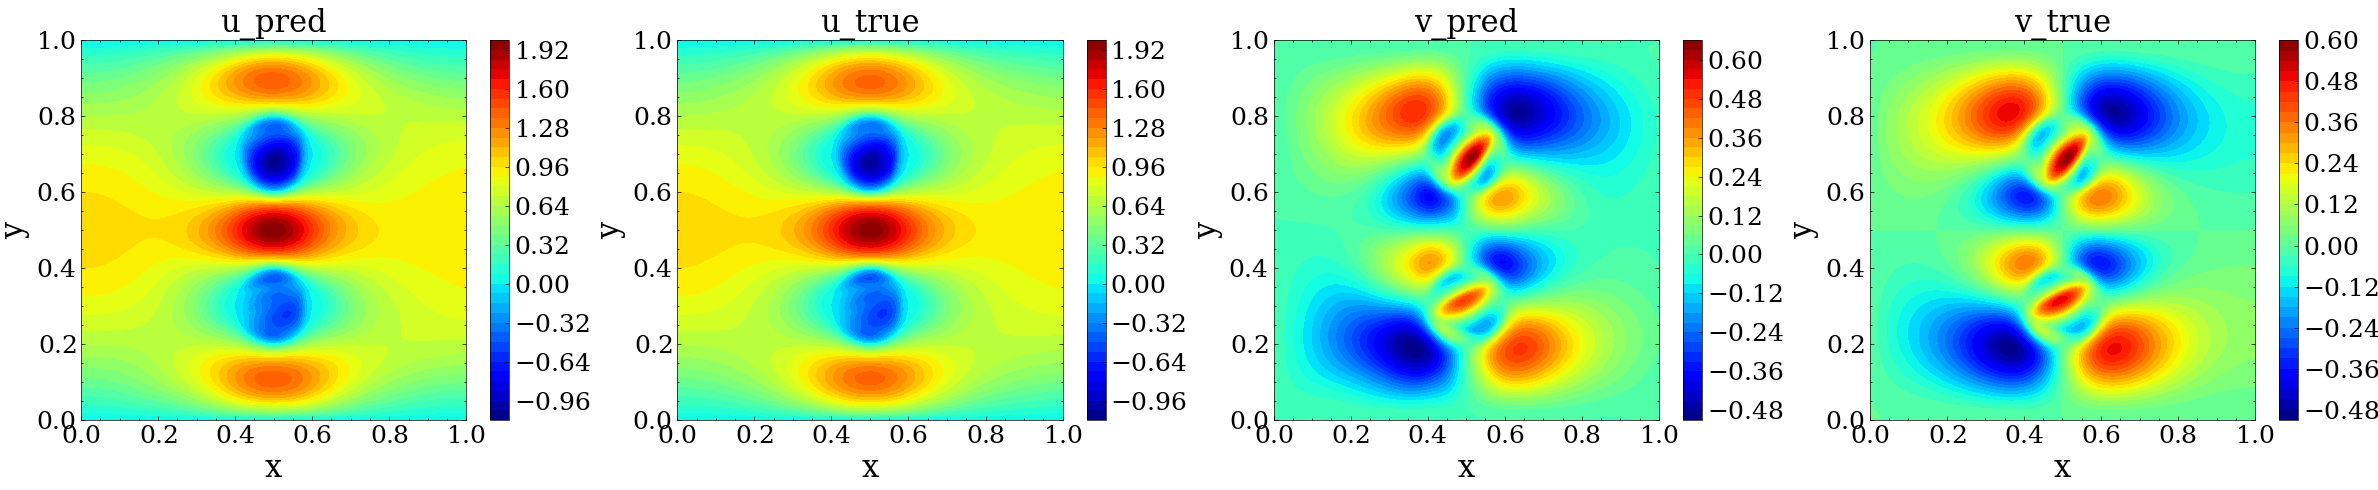

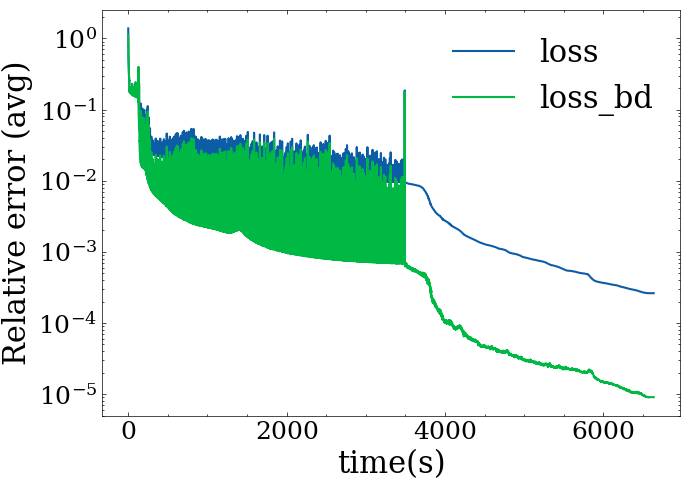

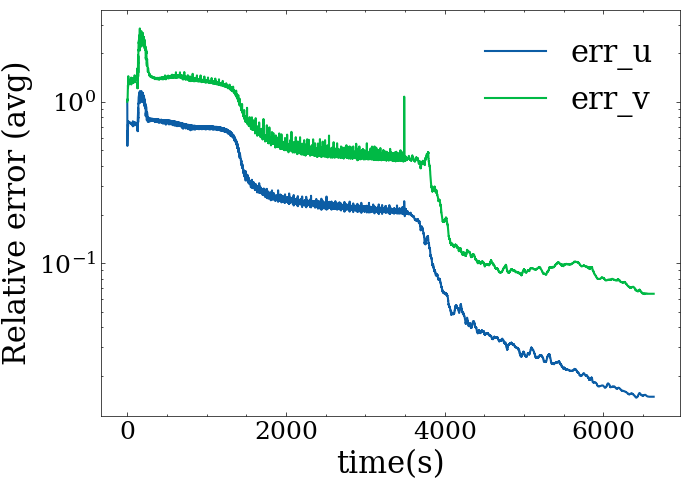

In [3]:
from torch.autograd import Variable
from Utils.PlotFigure import Plot
from Solvers.PINN import PINN
from Utils.Losses import *
myerror = MyLoss().lp_rel
# #####################################
# # load trained model
# #####################################
solver = PINN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_pinn_bestloss')

########################################
def get_values(x, solver, model):
    '''
    '''
    psi_p = model(x)
    psi, p = psi_p[...,0:1], psi_p[:,1:2]
    #
    dpsi = solver.grad(psi, [x])[0]
    u, v = dpsi[...,1:2], - dpsi[...,0:1]
    #
    s11, s22, s12 = psi_p[...,2:3], psi_p[...,3:4], psi_p[...,4:5]
    
    return u, v, p, s11, s22, s12
#
x_pred = Variable(x_test.to(device), requires_grad=True)
u_pred, v_pred, p_pred, _, _, _= get_values(x_pred, solver, model_trained['psi_p'])
u_pred = u_pred.detach().cpu()
v_pred = v_pred.detach().cpu()
p_pred = p_pred.detach().cpu()
#
print('The l2 error u is:', myerror(u_pred, u_test))
print('The l2 error v is:', myerror(v_pred, v_test))
######################################################
# show the solution
Plot.show_2d_list(x_test, [u_pred, u_test, v_pred, v_test], ['u_pred', 'u_true', 'v_pred', 'v_true'], ub=[1., 1.])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_pinn')
Plot.show_error([loss_saved['time']]*2, 
                [loss_saved['loss'],  loss_saved['loss_bd']],['loss', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_u', 'err_v'])